In [1]:
import findspark
findspark.init()
import pandas as pd
import pyspark
import random

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col

In [3]:
filename = "2004.csv"

In [4]:
def _init_spark():
    spark = SparkSession.builder.appName("Project").getOrCreate()
    sc = spark.sparkContext
    return spark, sc

In [5]:
spark, sc = _init_spark()

In [6]:
sqlContext = SQLContext(sc)

df = sqlContext.read.load(filename, 
                      format='com.databricks.spark.csv', 
                      header='true',
                      delimiter=',',
                      inferSchema='true')
df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: int, TaxiOut: int, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int]

In [7]:
# removing as is stated in the task along with the 'Year'
col_to_drop = ['ArrTime', 'ActualElapsedTime', 'AirTime', 'TaxiIn', 'Diverted', 
               'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Year']
df = df.drop(*col_to_drop)

In [ ]:
previous_amount = df.count()

In [8]:
# "CancelationCode" has too much "null" (98% of the data) we will remove it too. Others have no missing values except for "TailNum", that has only 127 values left.  
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|
+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|    0|         0|        0|      0|         0|         0|            0|        0|    127|             0|       0|       0|     0|   0|       0|      0|        0|         7001506|
+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+



In [9]:
# deletion of the "CancelationCode" and droping rows that contain "TailNum"
df = df.drop('CancellationCode')
df = df.filter(df.TailNum.isNotNull() )

In [ ]:
# Percentage of data saved dropping rows with null in the "TailNum" column
df.count()/previous_amount

In [10]:
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [11]:
# "ArrDelay" and "DepDelay" have string type. We cast them to Integer
df = df.withColumn("ArrDelay", df["ArrDelay"].cast(IntegerType()))
df = df.withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [ ]:
df.printSchema()

In [ ]:
df.filter(df)

In [12]:
corr_matrix = df.select([x[0] for x in df.dtypes if 'int' in x])

In [13]:
corr_matrix.show(5)

+-----+----------+---------+----------+----------+---------+--------------+--------+--------+--------+-------+---------+
|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|Cancelled|
+-----+----------+---------+----------+----------+---------+--------------+--------+--------+--------+-------+---------+
|    1|        12|        1|       630|       915|      462|           105|     -14|      -7|     599|     11|        0|
|    1|        13|        2|       630|       915|      462|           105|      -4|      -9|     599|     16|        0|
|    1|        14|        3|       630|       915|      462|           105|       5|       3|     599|     15|        0|
|    1|        15|        4|       630|       915|      462|           105|     -16|      -3|     599|     10|        0|
|    1|        16|        5|       630|       915|      462|           105|       3|       5|     599|     13|        0|
+-----+----------+---------+----

In [14]:
# I guess it is too pythonic and we nees to change it's PEARSON CORRELATION

[df.corr("ArrDelay", c[0]) for c in corr_matrix.dtypes]

[0.007980601268118464,
 0.0245611330916575,
 -0.01745605119494816,
 0.12517014253530656,
 0.12256764955531634,
 -0.002506685391161931,
 -0.012347988362953102,
 1.0,
 0.9031188980031882,
 -0.012188526790704167,
 0.25050862058300455,
 -0.026090903497301702]

In [15]:
NON_corr_matrix = df.select([x[0] for x in df.dtypes if x[1] !='int']).show(5)
NON_corr_matrix

+-------+-------------+-------+------+----+
|DepTime|UniqueCarrier|TailNum|Origin|Dest|
+-------+-------------+-------+------+----+
|    623|           UA| N805UA|   ORD| CLT|
|    621|           UA| N851UA|   ORD| CLT|
|    633|           UA| N436UA|   ORD| CLT|
|    627|           UA| N828UA|   ORD| CLT|
|    635|           UA| N831UA|   ORD| CLT|
+-------+-------------+-------+------+----+
only showing top 5 rows



In [16]:
# in order to visualize data, it has to be transformed in Pandas
#unfortunately, our dataset is too large, therefore we only have to get a sample
# in this case we only get 25% of our data, with no replacement

df_Pandas_25 = df.sample(False, 0.25, 42).toPandas()


In [32]:
#I will be using Altair for visualization, which accepts only 5000 max observations
#from here we can tell what airports have the longest trips

import altair as alt

alt.Chart(df_Pandas_25.sample(n=5000, random_state=1)).mark_point().encode(
    x='Origin',
    y='Distance',
    color='DayOfWeek',
)






alt.Chart(...)

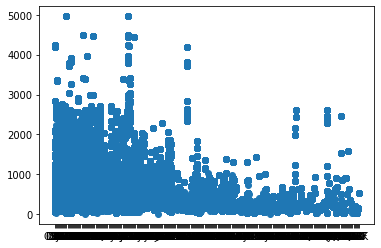

In [44]:
import matplotlib.pyplot as plt
plt.scatter(x=df_Pandas_25.Origin,
    y=df_Pandas_25.Distance)